In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats
import pickle

# load data

In [20]:
with open('../../data/movies.pkl', 'rb') as file:
    movies = pickle.load(file)


### US selection

In [ ]:
# function that extract if movies was created in US

def count_country(data, country = "United States of America"):
    total = 0
    for j in data:
        if j is not None:
            total += j.count(country)
    return total

us =  movies["Movie_countries"].apply(lambda x: count_country(x))
us_movies = movies.copy()
us_movies["count_us"] = us

nonus_movies = us_movies.loc[us_movies["count_us"]==0]
us_movies = us_movies.loc[us_movies["count_us"]>0]

len(nonus_movies)


16870

### get list of all genres 

In [10]:
#get the list of genre

genres_unique = []
for j in movies["Movie_genres"]:
    if j is not None:
        genres_unique.append(j[0])
genres_unique = np.unique(genres_unique)

In [11]:
# list a genre with increase in US movies

movies_before = us_movies.loc[ (us_movies.Movie_release_date.dt.year >1995) &(us_movies.Movie_release_date.dt.year < 2002)]
movies_after = us_movies.loc[ (us_movies.Movie_release_date.dt.year >=2002) &(us_movies.Movie_release_date.dt.year < 2007)]

genre_count_before = [0 for i in range(len(genres_unique))]
genre_count_after = [0 for i in range(len(genres_unique))]

genre_diff = [0 for i in range(len(genres_unique))]

for i in range(len(genres_unique)):
    sum = 0
    for j in movies_after["Movie_genres"]:
        if j is not None:
            sum += j.count(genres_unique[i])
    genre_count_after[i] = sum

    sum = 0
    for j in movies_before["Movie_genres"]:
        if j is not None:
            sum += j.count(genres_unique[i])
    genre_count_before[i] = sum

    if genre_count_before[i] > 0 :
        genre_diff[i] =   (genre_count_after[i] -   genre_count_before[i])



In [12]:
df = pd.DataFrame({
    'genre': genres_unique,
    'count_before': genre_count_before,
    'count_after': genre_count_after,
    'count_diff' :genre_diff
})
df["abs_diff"] = df['count_diff'].apply(lambda x: np.abs(x))

df.sort_values(by ="count_diff", ascending = False).head(50)
genres1 = df.sort_values(by ="count_diff", ascending = False).head(20).genre.values
genres = ["Documentary","Horror","Culture & Society","Biography","Comedy",'Social issues','Slasher',"Political cinema","War film","History"]

sivisier par la somme de tous les genres
histograme x genre
y pourcentage et voir si ça change

In [13]:
#function to count the genre
def count_genre(data, genre):
    total = 0
    for j in data["Movie_genres"]:
        if j is not None:
            total += j.count(genre)
    return total

def plot_percentage_movies_genre(data, genre, year_initial, year_end, focus_year,ax, fig):

    # the genre we focus on
    genre = genre  

    # count the number of movies have the given genre per year 
    movies_year = data.groupby(data.Movie_release_date.dt.year).apply(lambda x: count_genre(x, genre)).reset_index()
    movies_year.columns = ["year", "count"]

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by count 
    yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum')

    #percentage of a given genre
    percentage = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<year_end)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index < year_end)].values*100

    #plot
    ax.plot(movies_year.loc[(movies_year.year>year_initial  )&( movies_year.year<year_end)]["year"], percentage, color ='b')
    ax.plot([focus_year,focus_year],[percentage.min(), percentage.max()], color = 'r' )
    ax.set_title(genre)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks(np.arange(year_initial, year_end, 1))
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    fig.text(0.04, 0.5, 'percentage of movies from given genre per year', ha='center', rotation='vertical')
    ax.grid()

def plot_percentage_movies_genre_all(data, genres, year_initial, year_end, focus_year,nrows,ncols):

    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,25))

    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i][j]
            plot_percentage_movies_genre(movies, genres[i*ncols+j], year_initial, year_end, focus_year, ax, fig)


def plot_hist_movies_genre(data, genres_unique, year_initial, year_middle,  year_end):

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by count 
    before_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_before_yearly_movies = before_yearly_movies.loc[ (before_yearly_movies.Movie_release_date >year_initial) &(before_yearly_movies.Movie_release_date < year_middle)]["nb_genre"].sum()

    after_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_after_yearly_movies = after_yearly_movies.loc[ (after_yearly_movies.Movie_release_date >=year_middle) &(after_yearly_movies.Movie_release_date < year_end)]["nb_genre"].sum()


    movies_before = data.loc[ (data.Movie_release_date.dt.year >year_initial) &(data.Movie_release_date.dt.year < year_middle)]
    movies_after = data.loc[ (data.Movie_release_date.dt.year >=year_middle) &(data.Movie_release_date.dt.year < year_end)]

    genre_count_before = [0 for i in range(len(genres_unique))]
    genre_count_after = [0 for i in range(len(genres_unique))]

    for i in range(len(genres_unique)):
        sum = 0
        for j in movies_after["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_after[i] = sum/sum_after_yearly_movies*100

        sum = 0
        for j in movies_before["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_before[i] = sum/sum_before_yearly_movies*100

    df = pd.DataFrame({
        'genre': genres_unique,
        'count_before': genre_count_before,
        'count_after': genre_count_after
    })
    fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))
    axs[0].bar(df.genre, df.count_before)
    axs[0].set_xticklabels( df.genre, rotation = 90)
    axs[0].set_title("Before event")
    axs[0].tick_params(axis='both', which='major', labelsize=7)
    axs[0].set_yscale("log")

    axs[1].bar(df.genre, df.count_after)
    axs[1].set_xticklabels( df.genre, rotation = 90)
    axs[1].set_title("After event")
    axs[1].tick_params(axis='both', which='major', labelsize=7)
    axs[1].set_yscale("log")
    plt.show()


In [ ]:
def plot_hist_movies_genre(data, genres_unique, year_initial, year_middle, year_end, plot = False):
    # total number of genres for movies before and after the specified year range
    before_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_before_yearly_movies = before_yearly_movies.loc[
        (before_yearly_movies.Movie_release_date > year_initial) & 
        (before_yearly_movies.Movie_release_date < year_middle)
    ]["nb_genre"].sum()

    after_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_after_yearly_movies = after_yearly_movies.loc[
        (after_yearly_movies.Movie_release_date >= year_middle) & 
        (after_yearly_movies.Movie_release_date < year_end)
    ]["nb_genre"].sum()

    # Filter data before and after the middle year
    movies_before = data.loc[
        (data.Movie_release_date.dt.year > year_initial) & 
        (data.Movie_release_date.dt.year < year_middle)
    ]
    movies_after = data.loc[
        (data.Movie_release_date.dt.year >= year_middle) & 
        (data.Movie_release_date.dt.year < year_end)
    ]


    genre_count_before = [0 for _ in range(len(genres_unique))]
    genre_count_after = [0 for _ in range(len(genres_unique))]

    # Calculate the percentage of each genre before and after the event
    for i in range(len(genres_unique)):
        sum_genre = 0
        for j in movies_after["Movie_genres"]:
            if j is not None:
                sum_genre += j.count(genres_unique[i])
        genre_count_after[i] = sum_genre / sum_after_yearly_movies * 100

        sum_genre = 0
        for j in movies_before["Movie_genres"]:
            if j is not None:
                sum_genre += j.count(genres_unique[i])
        genre_count_before[i] = sum_genre / sum_before_yearly_movies * 100

    
    df = pd.DataFrame({
        'genre': genres_unique,
        'count_before': genre_count_before,
        'count_after': genre_count_after
    })
    if plot:
        # Plot
        fig, ax = plt.subplots(figsize=(15, 8))
        width = 0.35  
        x = np.arange(len(genres_unique)) 

        
        bars_before = ax.bar(x - width/2, df['count_before'], width, label='Before Event', color='blue')
        bars_after = ax.bar(x + width/2, df['count_after'], width, label='After Event', color='orange')


        ax.set_xticks(x)
        ax.set_xticklabels(df['genre'], rotation=90)
        ax.set_title("Genre distribution before and after event")
        ax.set_ylabel("Percentage (%)")
        ax.set_yscale("log")  # Log scale for the Y-axis if needed
        ax.legend()

        plt.tight_layout()
        plt.show()

    return df['count_before'].values, df['count_after'].values, 




In [15]:
from scipy import stats
before, after = plot_hist_movies_genre(us_movies, genres_unique, 1995,  2002,2009, plot = False)
t_statistic, p_value = stats.ttest_ind(before, after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.007692519103412265
p-value: 0.993865291384628


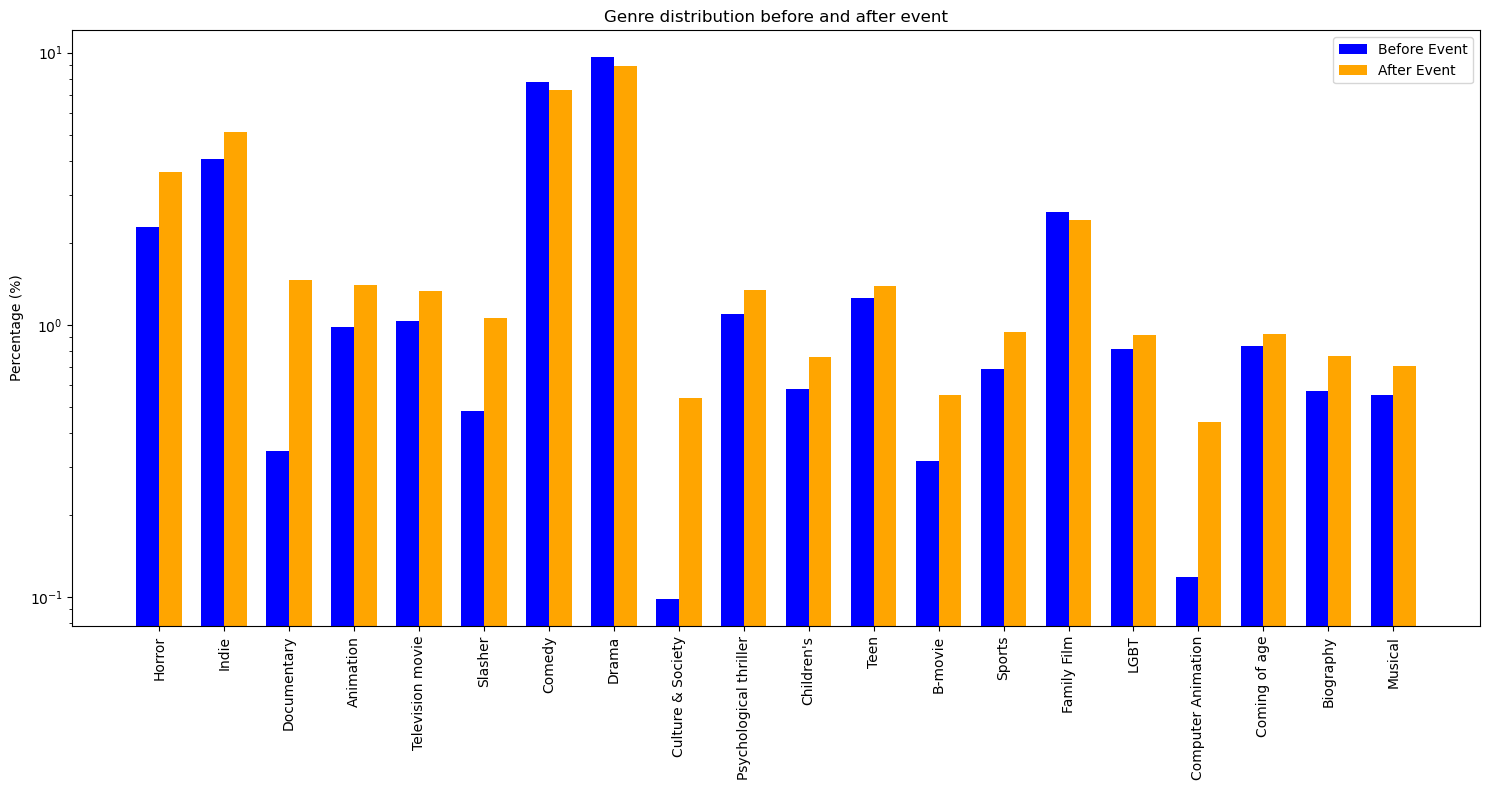

t-statistic: -0.3726955489446845
p-value: 0.7114458213811201


In [16]:
from scipy import stats
before, after = plot_hist_movies_genre(us_movies, genres1, 1995,  2002,2009, plot = True)
t_statistic, p_value = stats.ttest_ind(before, after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

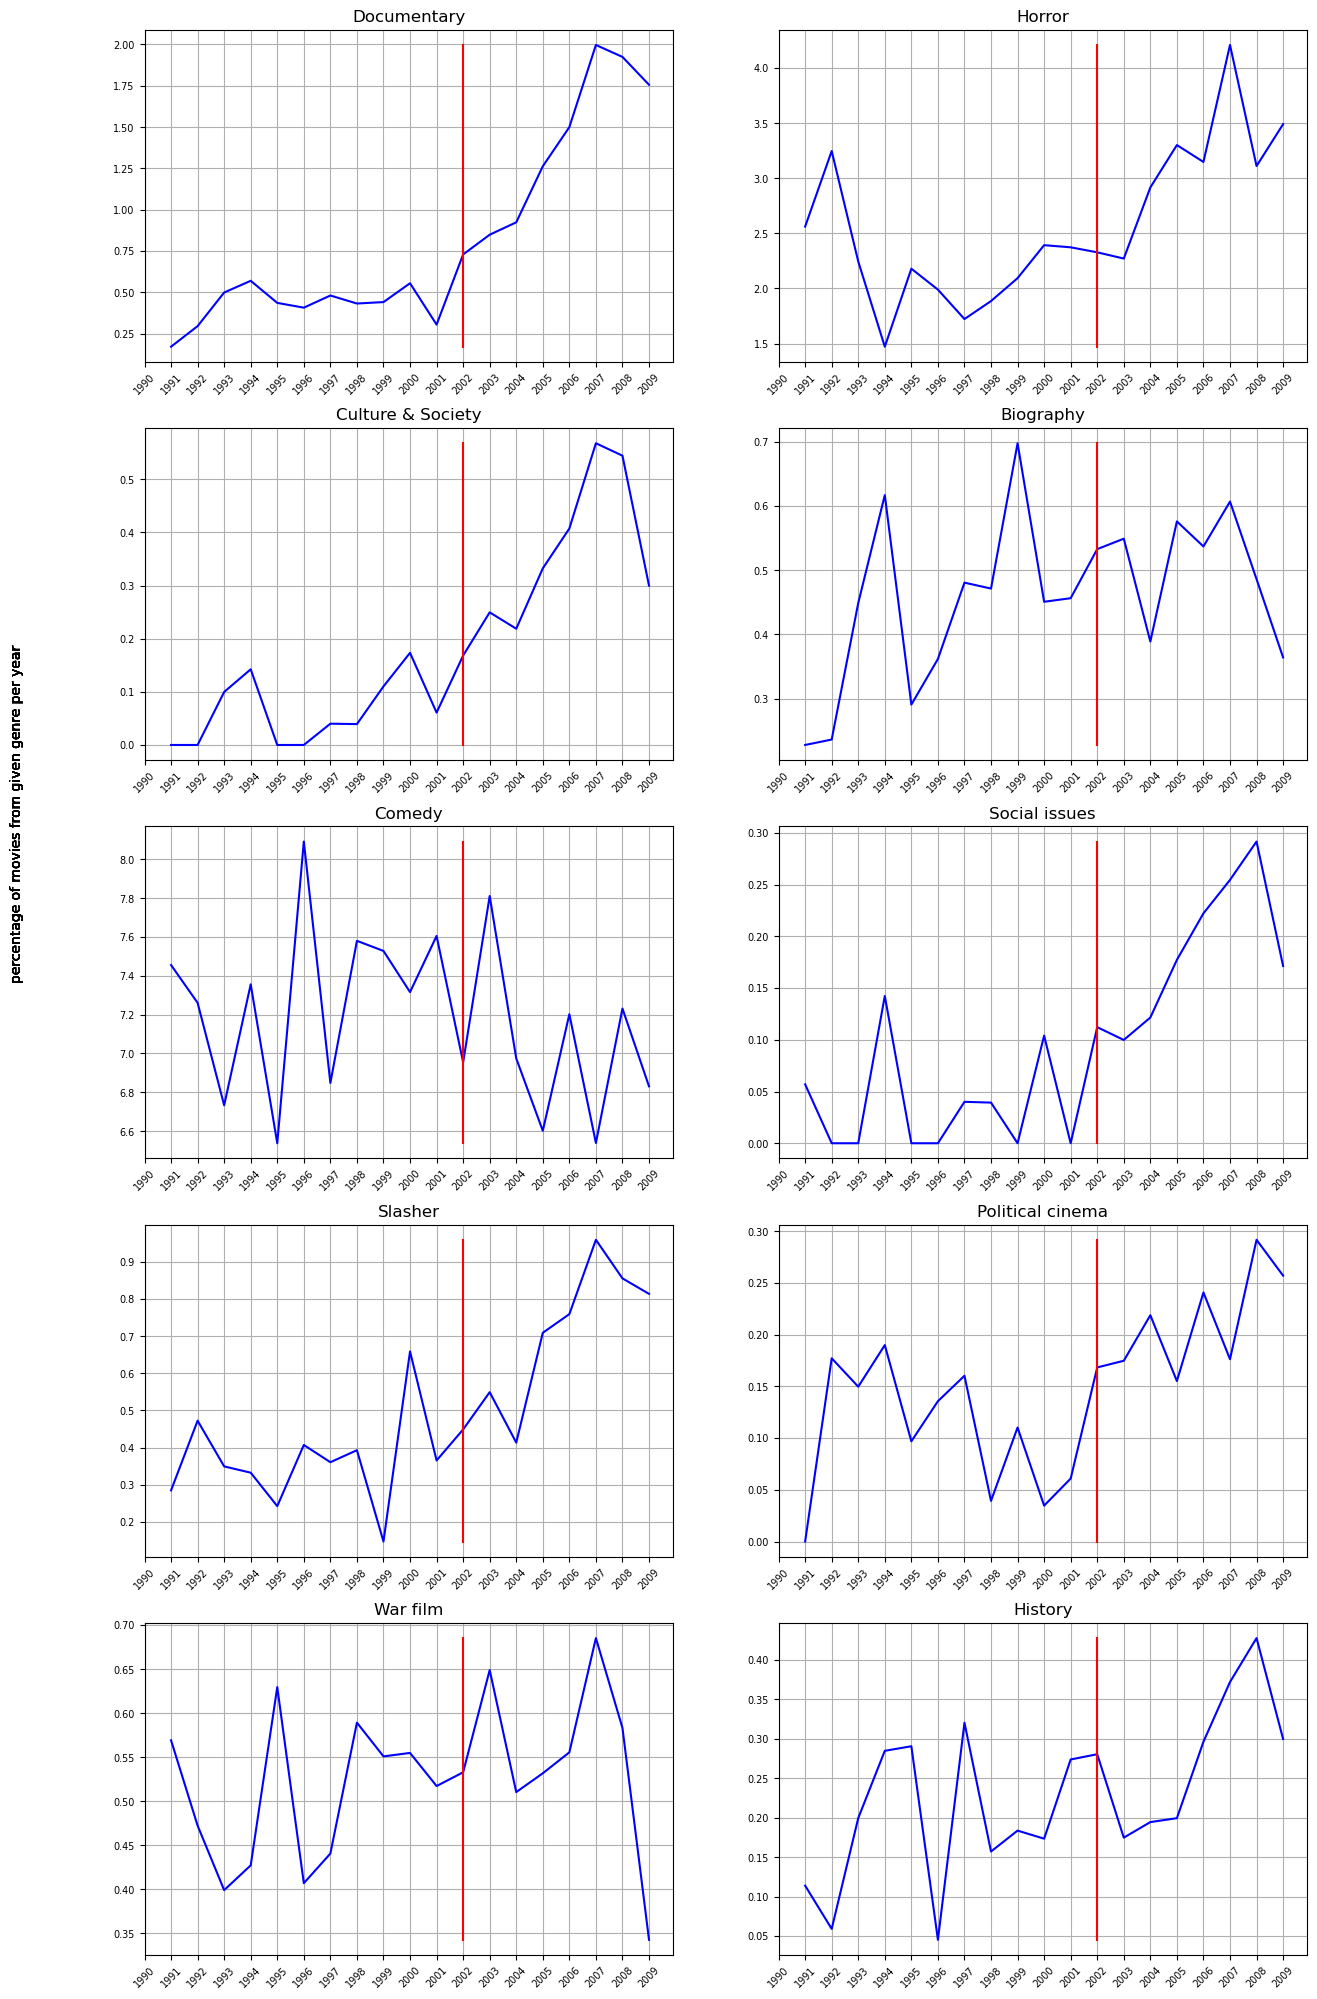

In [17]:
plot_percentage_movies_genre_all(movies,genres,1990, 2010, 2002,5,2)

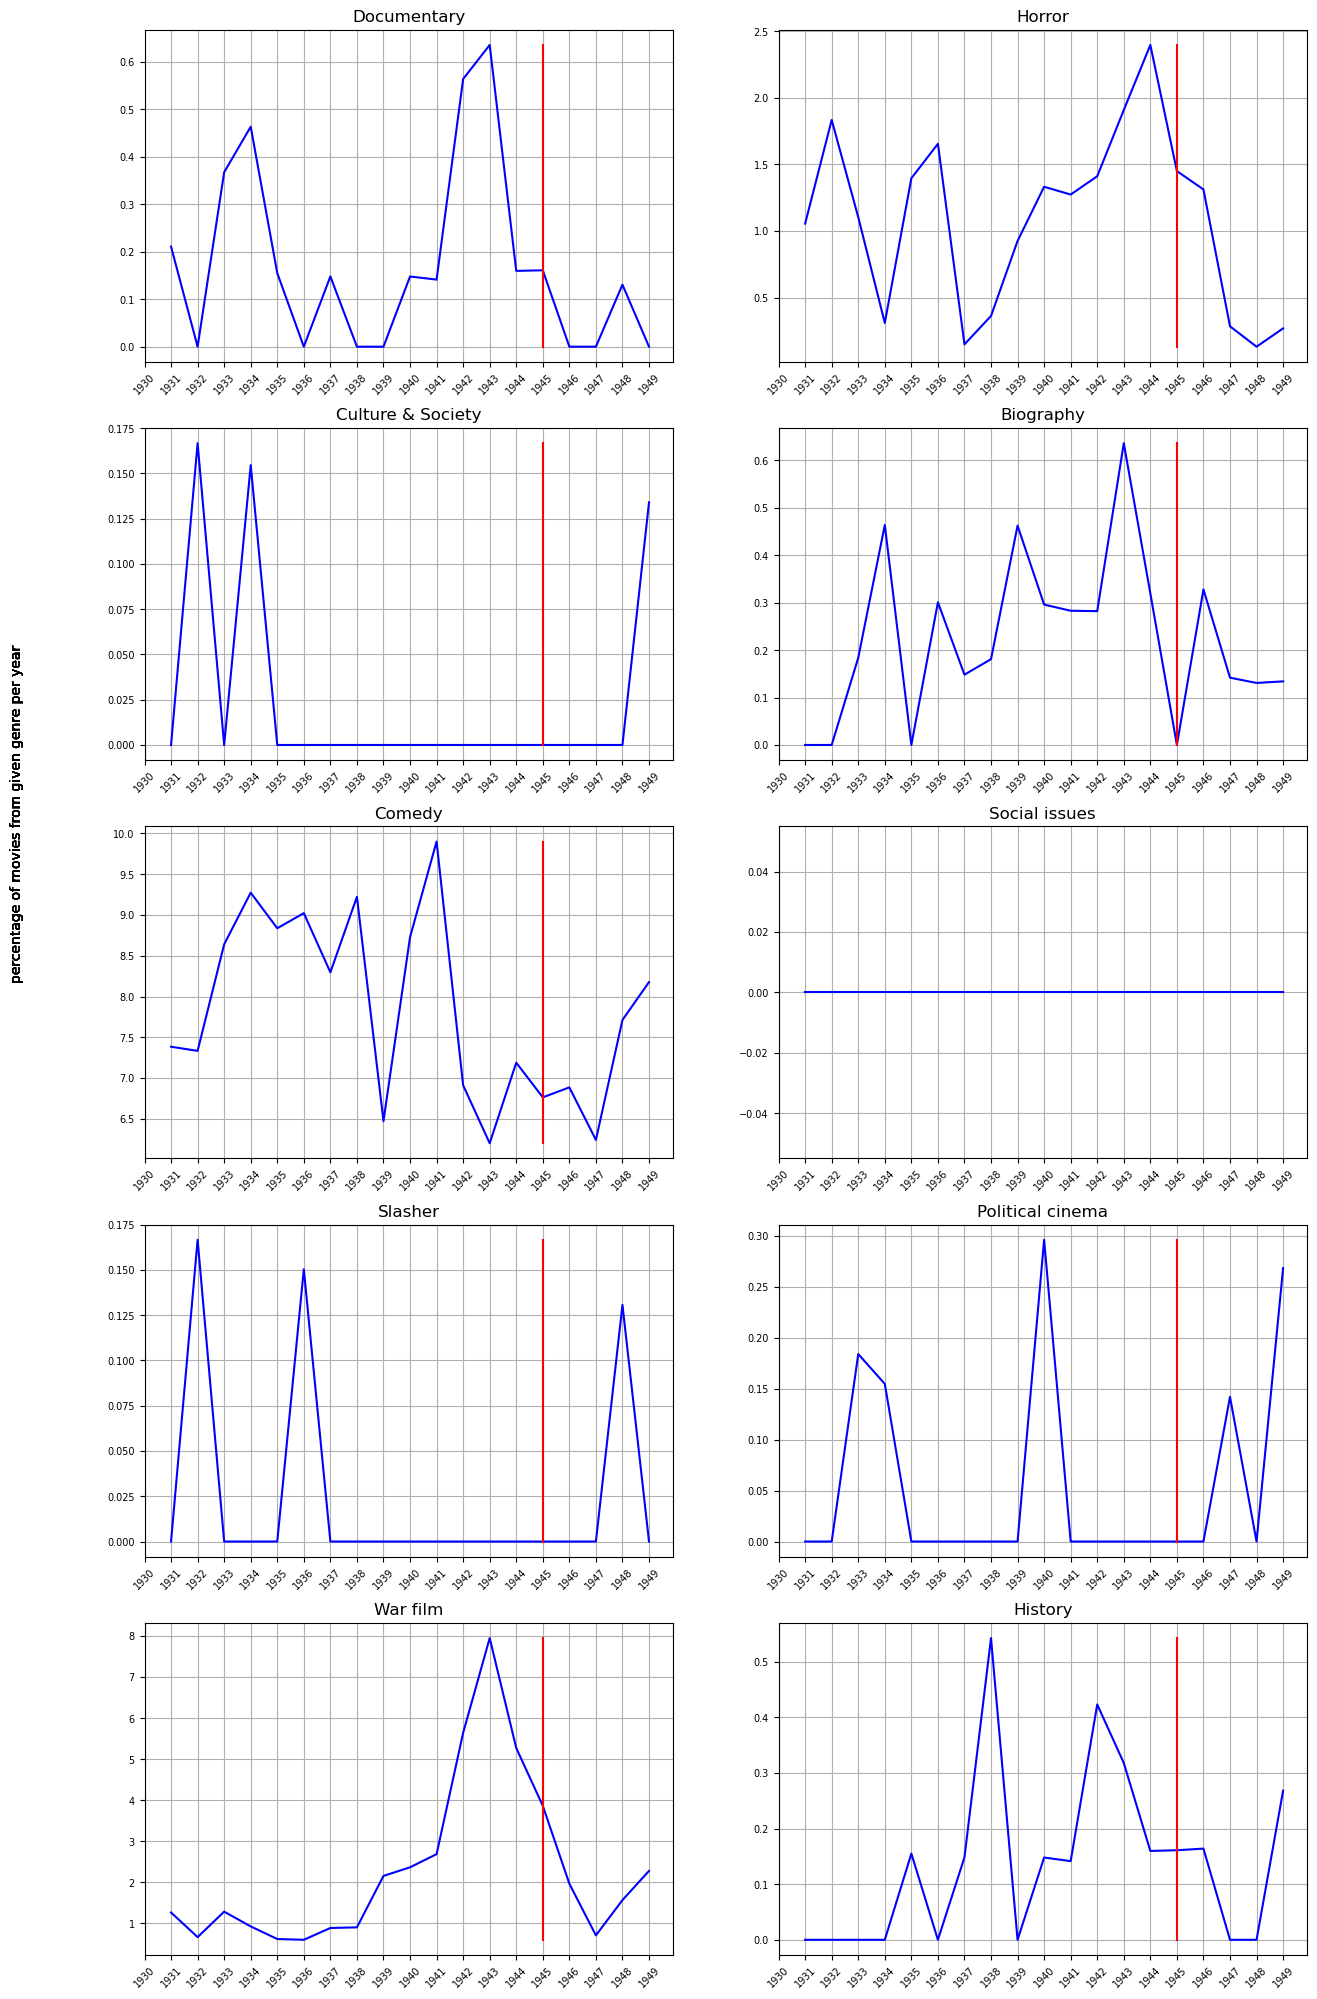

In [18]:
plot_percentage_movies_genre_all(movies,genres,1930, 1950, 1945,5,2)